In [1]:
import numpy as np
import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt

In [2]:
#the functions that I want to integrate
def Func(x):
    #return np.exp(-(x-0.3)**2/(2*0.1**2))
    return np.sin(x*10)*np.exp(-(x-0.3)**2/(2*0.05**2))

#the np.abs(Func) because it is needed for the calculation of the weights
def absFunc(x):
    return np.abs(Func(x))

A note on what VEGAS tries to do.

We have to calculate $I=\int_{0}^{1}dx f(x)$ and we want to do it in Monte Carlo.
We know that the variance is minimized if we sample from $p(x) \sim |f(x)|$.

What we do is to break the integration interval in N bins. In each bin we sample uniformly (the same number of sample in each bin). Now, if the bin-sizes are small in the regions that the integral has large contributions, then we effectivelly sample from $\sim |f(x)|$ (that is the most important regions get more points!).

VEGAS, iterativelly, tries to adjust each bin-size, so that the more important regions get smaller binsizes!
See next comment on how the grid is updated.

In [3]:
#define the numbers of bins and samples
NBins=100#number of bins
NSamplesPerBin=100 #number of samples per bin
NSamples=NBins*NSamplesPerBin #total number of sampes

#define the grid (initially uniform)
GridPoints=np.linspace(0,1,NBins+1)#a grid of NBins bins needs NBins+1 points to be defined!

#find the bin sizes (later I will defe a function to do this, beacuse I'll use it multiple times)
BinSize=[]
for i in range(NBins):
    BinSize.append(GridPoints[i+1]-GridPoints[i])
    

In [4]:
#define the distribution (not really needed here)
def Dist(i,number_of_bins=NBins):
    '''
    Since we have a constant distribution in each bin,
    we only need the number of the bin as input.
    '''
    return 1/float(number_of_bins)*1/float(BinSize[i])

#check the normalization
#np.sum(map(lambda i: Dist(i)*BinSize[i],range(NBins)))

In [5]:
def TotalInt(Func,Samples,GridPoints,BinSize):
    global NBins,NSamplesPerBin
    #calculate the integral of Func in [0,1]
    Integral=0
    for Bin in range(NBins):
        _min=GridPoints[Bin]
        _max=GridPoints[Bin+1]
        for Sample in Samples[Bin]:
            Integral+=Func(Sample)*BinSize[Bin]/float(NSamplesPerBin)

    return Integral

In [6]:
def BinInt(Func,Bin,Samples,GridPoints,BinSize):
    global NBins,NSamplesPerBin
    #calculate the integral of Func in the i Bin
    Integral=0
    _min=GridPoints[Bin]
    _max=GridPoints[Bin+1]
    for Sample in Samples[Bin]:
        Integral+=Func(Sample)*BinSize[Bin]/float(NSamplesPerBin)

    return Integral

A commend on how the grid is updated:

First, calculate $m_{i} \equiv K \times \frac{\int_{x_{i}}^{x_{i+1}} dx |f(x)|}{\int_{0}^{1} dx |f(x)|}$ (K is a large constant) or for smoother convergence $m_{i} \to K \left[ \times \frac{\frac{m_{i}}{K}-1}{log\left( \frac{m_{i}}{K} \right) } \right]^{\alpha}$ ($\alpha$ is a constand ~1)

These m's weight how important the $i^{th}$ bin is. So we could subdevide each bin to $m_{i}+1$ sub-bins 
and then sample uniformly in each oe of them. However this would be extremely slow.
So,we need to merge some of them to restore the original number of bins (N). To do this in a way 
that  we'll effectively approximate |f(x)|, we redefine the new $\Delta x's$ as:

$$
\dfrac{\frac{\Delta x_{i}}{m_{i}+1}}{\frac{\Delta x_{i+1}}{m_{i+1}+1}}=\frac{\Delta x_{i}^{\prime}}{\Delta x_{i+1}^{\prime}}
$$

In this way, we keep the relative density of the $m_{i}+1$ sub-divisions of each bin! 
The constraint in orde to do this consistently (we integrate in [0,1]) is:

$$
\sum \limits_{i=0}^{N-1} \Delta x_{i}^{\prime} =1
$$

The equations above give us
$$
\Delta x_{i}^{\prime}=\frac{\Delta x_{i}}{\Delta x_{0}} \frac{m_{0}+1}{m_{i}+1}\Delta x_{0}^{\prime}
$$


and

$$
\Delta x_{0}^{\prime}=\frac{\Delta x_{0}}{m_{0}+1}
\left( \sum \limits_{i=0}^{N-1} \frac{\Delta x_{i}}{m_{i}+1} \right)^{-1}
$$

NOTE: When the algorithm converges, i.e $\Delta x_{i}^{\prime} \approx \Delta x_{i}$, 
then you can see that $ \frac{m_{i}+1}{m_{0}+1} \approx 1$. That is, VEGAS effectively
breaks the interal of integration in such way that all bins contribute the same!

---

In some cases, one bin could so important that its contribution is very close to 100\%.
So we need to also smooth the m's (before doing anything else):

$$
m_{0} \to \frac{m_{0}+m_{1}}{2} \\
m_{N-1} \to \frac{m_{N-1}+m_{N-2}}{2} \\
m_{i} \to \frac{m_{i-1}+m_{i}+m_{i+1}}{3}
$$

NOTE: this makes the convergence slightly slower, but safer... So it should be optional and used if it fails otherwise.


In [7]:
NRuns=200 #number of runs. This refines the grid.
alpha=0.1#the aplha parameter
K=1000. #the K parameter
_TINY=1.e-50#define a tiny number (if a weight is smaller than that, then set this weight to 1)
_SMOOTH=False#Choose if you want to first smooth the m_{i}'s (see comment above)

for Run in range(NRuns):
    #Generate the samples
    #initialize Samples array with dimensions [NSamplesPerBin][NBins] (for simplicity)
    Samples=[[0 for i in range(NSamplesPerBin)] for j in range(NBins)]
    for Bin in range(NBins):
        _min=GridPoints[Bin]
        for Sample in range(NSamplesPerBin):
            #samples iin each bin (ie in [GridPoints[Bin],GridPoints[Bin+1]])
            Samples[Bin][Sample]=np.random.rand()*BinSize[Bin]+_min


    #calculate the m_i's (call them weights)
    Weights=[ 0 for i in range(NBins)]
    Total=TotalInt(absFunc,Samples,GridPoints,BinSize)
    for Bin in range(NBins):
        Weights[Bin]=BinInt(absFunc,Bin,Samples,GridPoints,BinSize)/Total#this is m_{i}/K in Lapage's paper.
        #I need he log of Weights[Bin]. But if it is small, then the log is not a good choice
      
    if _SMOOTH:
        #smooth the weights
        Weights[0]=(Weights[0]+Weights[1])/2.
        Weights[-1]=(Weights[-1]+Weights[-2])/2.
        for Bin in range(1,NBins-1):
            Weights[Bin]=(Weights[Bin-1]+Weights[Bin]+Weights[Bin+1])/3.

    
    for Bin in range(NBins):
        if Weights[Bin]>_TINY:
            Weights[Bin]=( (Weights[Bin]-1)/float(np.log(Weights[Bin])) )**alpha
        else:
            Weights[Bin]=Weights[Bin]**alpha#if Weights[Bin]<_TINY, then the log explodes. So it is better to se it this way
            
        Weights[Bin]=K*Weights[Bin]+1. #we should have at least one sub-bin for each bin!
        

    #initialize the new GridPoints
    NewGridPoints=[0 for i in GridPoints]
    NewBinSize=[0 for i in BinSize]


    #calculate the newBinSize[0], so that all entries in newBinSize add up to 1. 
    _tmp=0
    for j in range(NBins):
        _tmp+=BinSize[j]/Weights[j]
    NewBinSize[0]=_tmp**(-1)*BinSize[0]/Weights[0]

    #You can now calculate the others as well
    for i in range(1,NBins):
        NewBinSize[i]=NewBinSize[0]*(BinSize[i]/BinSize[0]*Weights[0]/Weights[i])


    #set the BinSize to be the NewBinSize
    del BinSize
    BinSize=NewBinSize[:]

    #find the new GridPoints from the new BinSize
    for i in range(1,NBins+1):
        NewGridPoints[i]=NewGridPoints[i-1]+BinSize[i-1]

    del GridPoints
    GridPoints=NewGridPoints[:]

In [8]:
#uncomment to interrupt at this point
#raise KeyboardInterrupt

You need to find appropriate stopping conditions for this.
One idea is to run batches (of course!) and then see when the variance becomes acceptable!

As it is stated in the literature, use the chi-squared estimator for the batches, because
in this estimator the batch means with larger variance contribute less. Thus, the calculation 
is more accurate.

<IPython.core.display.Javascript object>


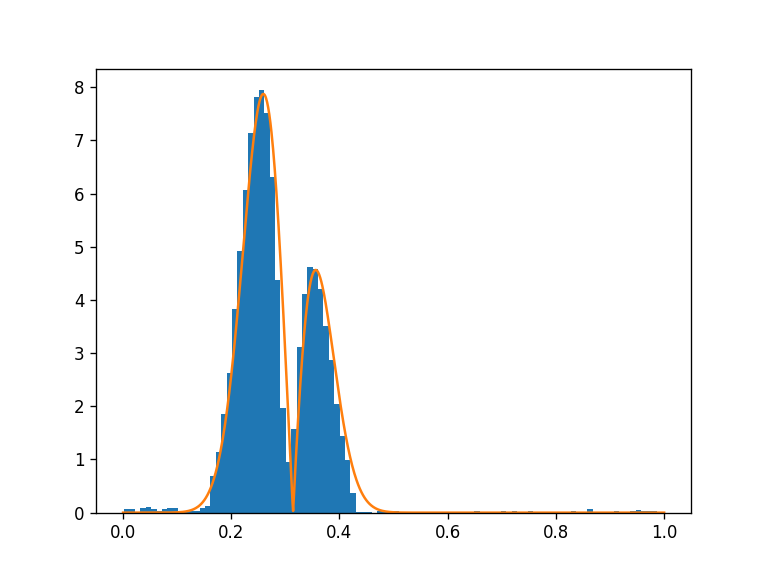

In [9]:
#Once the grid is refined, you can sample and see that the histogram of the samlpes, mathes the normalized |f(x)|.

Samples=[[0 for i in range(NSamplesPerBin)] for j in range(NBins)]
for Bin in range(NBins):
    _min=GridPoints[Bin]
    for Sample in range(NSamplesPerBin):
        #samples iin each bin (ie in [GridPoints[Bin],GridPoints[Bin+1]])
        Samples[Bin][Sample]=np.random.rand()*BinSize[Bin]+_min

        
plt.hist([i for f in Samples for i in f ],bins=NBins,density=1)

from scipy.integrate import quad
_norm=quad(absFunc,0,1)[0]
_x=np.linspace(0,1,1000)
_y=[absFunc(i)/_norm for i in _x]
plt.plot(_x,_y)

plt.show()

In [10]:
#You can see that the integral ca now be calculated
Samples=[[0 for i in range(NSamplesPerBin)] for j in range(NBins)]

for Bin in range(NBins):
    _min=GridPoints[Bin]
    for Sample in range(NSamplesPerBin):
        #samples iin each bin (ie in [GridPoints[Bin],GridPoints[Bin+1]])
        Samples[Bin][Sample]=np.random.rand()*BinSize[Bin]+_min


TotalInt(Func,Samples,GridPoints,BinSize)

0.0160088579776648

In [11]:
quad(Func,0,1)[0]

0.015608519853793454